In [7]:
import tensorflow as tf
print(tf.config.list_physical_devices())

import gc
class FreeMemory(tf.keras.callbacks.Callback):
    def __init__(self, log_freq=0):
        super().__init__()
        self.log_freq = log_freq
    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.log_freq == 0:
            print(f'epoch {epoch} ended, info: {logs}')
        tf.keras.backend.clear_session()
        gc.collect()

2023-10-14 20:38:46.319251: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-10-14 20:38:49.092957: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-14 20:38:49.111967: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-14 20:38:49.112243: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [8]:
import numpy as np
raw_data = np.load('/host/code/proccessed_data/x_y_phi_pt.npy')
print(raw_data)
event_ids = np.unique(raw_data[:,0]).astype('int32')

points_num = 3
new_records = []
for event_id in event_ids:
    particle_data = raw_data[raw_data[:,0] == event_id][:,np.array([False, True, True, True, False])]
    # particle_data = raw_data[raw_data[:,0] == event_id][:,np.array([False, True, True, True, True])]
    if len(particle_data) < points_num:
        continue
    order = np.argsort(np.abs(particle_data[:,0] + 1.j * particle_data[:,1]))
    particle_data_sorted = particle_data[order]
    new_record = []
    for point in range(points_num):
        new_record.append(particle_data_sorted[point][0])
        new_record.append(particle_data_sorted[point][1])
    new_record.append(particle_data_sorted[-1][-1])
    # new_record.append(particle_data_sorted[-1][-2])
    # new_record.append(particle_data_sorted[-1][-1])
    new_records.append(new_record)

print(len(new_records))

[[ 0.00000000e+00 -2.07658215e+01  2.53001633e+01  2.25652742e+00
   6.99481201e+00]
 [ 0.00000000e+00 -4.30311394e+01  5.22786179e+01  2.25652742e+00
   6.99481201e+00]
 [ 0.00000000e+00 -4.40572853e+01  5.35139160e+01  2.25652742e+00
   6.99481201e+00]
 ...
 [ 9.99900000e+03  3.09907928e+02  1.57217087e+02  4.92932558e-01
   4.42384100e+00]
 [ 9.99900000e+03  2.69411377e+02  1.37617249e+02  4.92932558e-01
   4.42384100e+00]
 [ 9.99900000e+03  2.28952026e+02  1.17901054e+02  4.92932558e-01
   4.42384100e+00]]
9943


In [9]:
np.random.shuffle(new_records)
data_x = []
for record in new_records:
    row = []
    for i in range(0, 2*points_num, 2):
        row.append(record[i] + 1.j * record[i+1])
    data_x.append(row)
data_x =  np.asarray(data_x)
data_y = np.asarray(new_records)[:,-1]
# data_y = np.asarray(new_records)[:,-1]*np.exp(1.j * np.asarray(new_records)[:,-2])

In [14]:
import cvnn.layers as complex_layers
from cvnn.losses import ComplexMeanSquareError
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import Loss

class AngleError(Loss):
    def call(self, y_true, y_pred):
        y_pred = tf.convert_to_tensor(y_pred)
        y_true = tf.convert_to_tensor(y_true)
        return tf.reduce_mean(tf.abs(tf.atan2(tf.sin(y_true - y_pred), tf.cos(y_true - y_pred))))

model = tf.keras.models.Sequential()
model.add(complex_layers.ComplexInput(input_shape=(points_num,)))
model.add(complex_layers.ComplexDense(units=64, activation='pol_tanh'))
model.add(complex_layers.ComplexDense(units=64, activation='pol_tanh'))
model.add(complex_layers.ComplexDense(units=1, activation='convert_to_real_with_abs'))
model.compile(loss=AngleError(), optimizer=SGD(learning_rate=0.01, momentum=0.1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 complex_dense (ComplexDens  (None, 64)                512       
 e)                                                              
                                                                 
 complex_dense_1 (ComplexDe  (None, 64)                8320      
 nse)                                                            
                                                                 
 complex_dense_2 (ComplexDe  (None, 1)                 130       
 nse)                                                            
                                                                 
Total params: 8962 (35.01 KB)
Trainable params: 8962 (35.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
history = model.fit(data_x, data_y, shuffle=False, epochs=200, validation_split=0.2, verbose=0, callbacks=[FreeMemory(10)])

epoch 0 ended, info: {'loss': 0.984529435634613, 'val_loss': 0.9461699724197388}
epoch 10 ended, info: {'loss': 0.479773610830307, 'val_loss': 0.5840052962303162}
epoch 20 ended, info: {'loss': 0.3561125695705414, 'val_loss': 0.433891624212265}
epoch 30 ended, info: {'loss': 0.27437761425971985, 'val_loss': 0.36238840222358704}
epoch 40 ended, info: {'loss': 0.21920259296894073, 'val_loss': 0.30215200781822205}
epoch 50 ended, info: {'loss': 0.19012035429477692, 'val_loss': 0.24041561782360077}
epoch 60 ended, info: {'loss': 0.16454730927944183, 'val_loss': 0.19443531334400177}
epoch 70 ended, info: {'loss': 0.14761921763420105, 'val_loss': 0.1981286257505417}
epoch 80 ended, info: {'loss': 0.13983269035816193, 'val_loss': 0.14269046485424042}
epoch 90 ended, info: {'loss': 0.12723760306835175, 'val_loss': 0.1471884697675705}
epoch 100 ended, info: {'loss': 0.11713000386953354, 'val_loss': 0.1489330530166626}
epoch 110 ended, info: {'loss': 0.10895628482103348, 'val_loss': 0.1662580072

1st percentile of train loss:       7.9014e-02
1st percentile of validation loss:  7.4165e-02


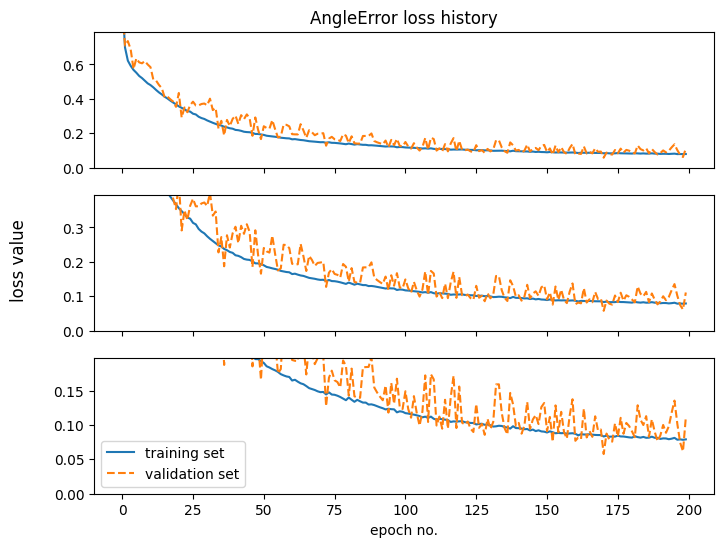

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
def make_dataframe(fit_history):
    df = pd.DataFrame(fit_history.history)
    df['epoch'] = fit_history.epoch
    return df

def plot_loss_history(fit_history, title = "", threshold_multiplier = 10):

    df = make_dataframe(fit_history)

    train_1st_percentile = np.percentile(df['loss'].values, 1)
    val_1st_percentile = np.percentile(df['val_loss'].values, 1)
    print(f'1st percentile of train loss:       {train_1st_percentile:.4e}')
    print(f'1st percentile of validation loss:  {val_1st_percentile:.4e}')
    
    threshold = np.maximum(train_1st_percentile, val_1st_percentile)
    fig, axes = plt.subplots(3, sharex=True, figsize=(8,6))
    axes[0].set_title(f"{title} loss history")
    for axis in axes:
        axis.set_ylim((0, threshold_multiplier*threshold))
        axis.plot(df['epoch'], df['loss'], label='training set')
        axis.plot(df['epoch'], df['val_loss'], linestyle='dashed', label='validation set')
        threshold_multiplier /= 2
    axes[-1].legend(loc="lower left")
    axes[-1].set_xlabel("epoch no.")
    fig.supylabel("loss value")

plot_loss_history(history, "AngleError")

In [ ]:
raise "spacer"

In [ ]:
import keras_tuner as kt

def model_builder(hp):
  model = tf.keras.models.Sequential()
  model.add(complex_layers.ComplexInput(input_shape=(points_num,)))
  # model.add(complex_layers.ComplexDense(units=64, activation='pol_tanh'))
  # model.add(complex_layers.ComplexDense(units=64, activation='pol_sigmoid'))
  
  hp_hidden_layer_activation = hp.Choice('hidden_layer_activation', values=['_pol_tanh', '_pol_sigmoid', '_pol_selu'])
  model.add(complex_layers.ComplexDense(64, activation=hp_hidden_layer_activation[1:]))
  
  hp_output_layer_activation = hp.Choice('output_layer_activation', 
                                         values=['_cast_to_real', '_sigmoid_real', '_softmax_real_with_abs', '_softmax_real_with_avg', '_softmax_real_with_mult', 
                                                 '_softmax_of_softmax_real_with_mult', '_softmax_of_softmax_real_with_avg', '_convert_to_real_with_abs', '_softmax_real_with_polar'])
  
  model.add(complex_layers.ComplexDense(1, activation=hp_output_layer_activation[1:]))
  
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  hp_optimizer_name = hp.Choice('optimizer', values=['adam', 'sgd'])
  if hp_optimizer_name == 'adam':
    hp_optimizer = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate)
  elif hp_optimizer_name == 'sgd':
    hp_optimizer = tf.keras.optimizers.SGD(learning_rate=hp_learning_rate)
  else:
      raise
    
  model.compile(optimizer=hp_optimizer,
                loss=AngleError(),
                # callbacks=[FreeMemory()]
                )

  return model

Using TensorFlow backend


In [ ]:
cvnn_tuner = kt.Hyperband(model_builder,
                     objective='val_loss',
                     max_epochs=30,
                     factor=10,
                     directory='/host/keras_tuner',
                     project_name='triplets_phi')

while True:
    try:
        cvnn_tuner.search(data_x, data_y, epochs=60, validation_split=0.2)
    except:
        continue
    break

Trial 18 Complete [00h 00m 32s]
val_loss: 1.5697219371795654

Best val_loss So Far: 0.3859211206436157
Total elapsed time: 00h 02m 58s


In [ ]:
cvnn_best_hps = cvnn_tuner.get_best_hyperparameters(num_trials=1)[0]
cvnn_best_hps.values

{'hidden_layer_activation': '_pol_sigmoid',
 'output_layer_activation': '_cast_to_real',
 'learning_rate': 0.01,
 'optimizer': 'adam',
 'tuner/epochs': 3,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 1,
 'tuner/round': 0}

In [ ]:
cvnn_model = cvnn_tuner.hypermodel.build(cvnn_best_hps)
cvnn_history = cvnn_model.fit(data_x, data_y, epochs=100, validation_split=0.2, verbose=0, callbacks=[FreeMemory()])

epoch 0 ended, info: {'loss': 0.7131155133247375, 'val_loss': 0.5886847972869873}
epoch 1 ended, info: {'loss': 0.5532516837120056, 'val_loss': 0.5000545382499695}
epoch 2 ended, info: {'loss': 0.4647427797317505, 'val_loss': 0.41140231490135193}
epoch 3 ended, info: {'loss': 0.37393832206726074, 'val_loss': 0.3803800046443939}
epoch 4 ended, info: {'loss': 0.32192346453666687, 'val_loss': 0.3642089366912842}
epoch 5 ended, info: {'loss': 0.340244859457016, 'val_loss': 0.43611618876457214}
epoch 6 ended, info: {'loss': 0.27606821060180664, 'val_loss': 0.219490185379982}
epoch 7 ended, info: {'loss': 0.23814068734645844, 'val_loss': 0.2717668414115906}
epoch 8 ended, info: {'loss': 0.22824719548225403, 'val_loss': 0.33855119347572327}
epoch 9 ended, info: {'loss': 0.25721609592437744, 'val_loss': 0.5262958407402039}
epoch 10 ended, info: {'loss': 0.2202150821685791, 'val_loss': 0.1669847071170807}
epoch 11 ended, info: {'loss': 0.15297278761863708, 'val_loss': 0.13106639683246613}
epoch

1st percentile of train loss:       9.7435e-02
1st percentile of validation loss:  6.7288e-02


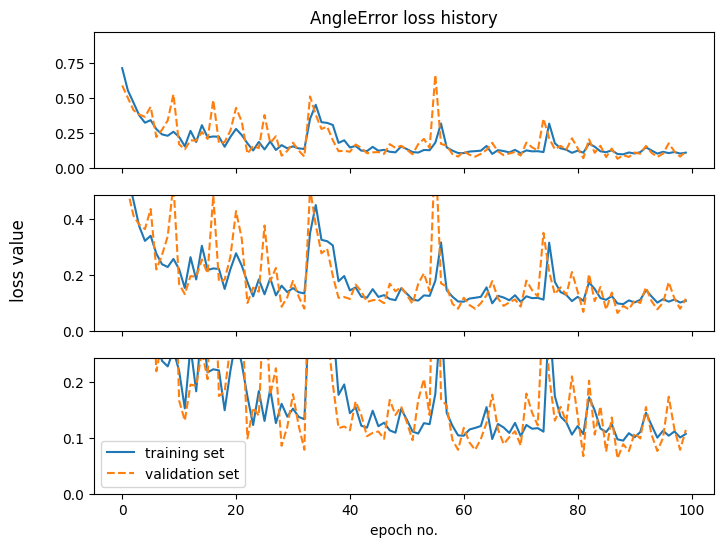

In [ ]:
plot_loss_history(cvnn_history, "AngleError")